# 4) Curve possibilità pluviometrica

Curve che, assegnato il tempo di ritorno, danno l'altezza di precipitazione in funzione di una durata di precipitazione prefissata

## Caricamento librerie

In [43]:
import os
from pandas import *
import pandas as pd
import numpy as np
from numpy import linspace
import datetime as datetime
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.stats import genextreme, gumbel_r
from statsmodels.distributions.empirical_distribution import ECDF
from pylab import plot

## Caricamento dati

In [2]:
# Dati sperimentali
data = pd.ExcelFile('MassimiDiPrecipCavalese.xls')
data
data.sheet_names
df = data.parse('DATI', header = 2)
df.columns
df.rename(columns = {'anno':'Anno'}, inplace = True)
df.set_index("Anno", inplace = True)
df.head()

,1 ora,3 ore,6 ore,12 ore,24 ore
Anno,,,,,
1962,24.0,41.6,42.8,42.8,60.5
1963,10.4,15.0,18.8,32.0,35.8
1964,28.6,34.8,38.4,40.0,56.4
1965,18.8,30.2,31.0,35.2,39.2
1966,21.0,22.0,33.0,59.6,102.2


Viene caricato il dataframe contenente i migliori parametri determinati tramite il test di Pearson.

In [6]:
os.listdir()
df_best = pd.read_pickle("df_best_aEb")

## Calcolo delle curve di possibilità pluviometrica

Per definire e successivamente plottare le curve di possibilità pluviometrica occorre definire alcune funzioni.

In [8]:
# Funzione sui quantili
def quantili(data, qu):
    rv1h = gumbel_r(loc = data["a"], scale = data["b"]) 
    return rv1h.ppf(qu) 

In [9]:
# Funzione che permette di determinare la probabilità con i vari tempi di ritorno
def altezze(data, Tr):
    lista = []        
    for i in data.columns :
        lista.append(quantili(data[i], 1 - 1/Tr))
    return lista

Vengono definiti i tempi di ritorno pari a 10, 20, 100 anni.

In [11]:
Tempo_ritorno = [10, 20, 100]

Vengono generati i punti che mostrano la relazione tra altezza di precipitazione, tempo di ritorno e durata. Questi punti si ottengono intersecando le curve di probabilità con le rette che identificano i tempi di ritorno.

In [32]:
punti = []
ore = ["1 ora", "3 ore", "6 ore", "12 ore", "24 ore"]
temp_rit = ["Tr = 10", "Tr = 20","Tr = 100"]
for i in range(len(Tempo_ritorno)):
    punti.append(altezze(df_best, Tempo_ritorno[i]))
df_h_mm_0 = pd.DataFrame(punti, index = temp_rit, columns = ore).T
df_h_mm_0

,Tr = 10,Tr = 20,Tr = 100
1 ora,29.977022,34.097166,43.426680
3 ore,38.825644,43.579456,54.343826
6 ore,51.043656,57.518570,72.180145
12 ore,65.210366,73.361385,91.818277
24 ore,84.001019,94.472759,118.184612


## Realizzazione dei grafici relativi alle curve di possibilità pluviometrica

Vengono costruite le curve sperimentali di possibilità pluviometrica (punti) nel piano bilogaritmico.

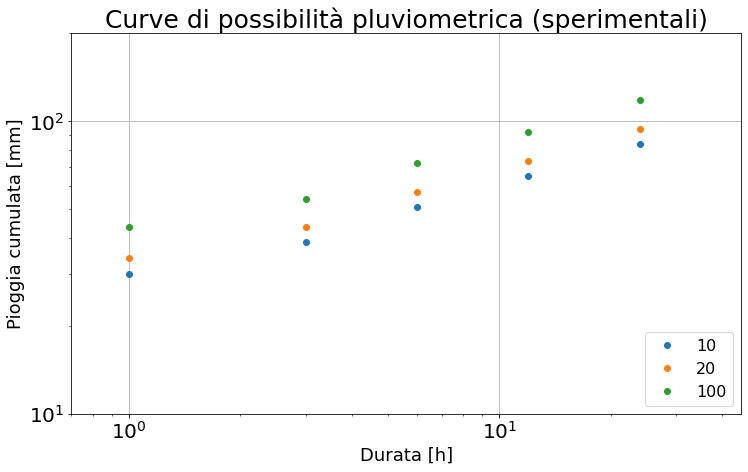

In [33]:
df_h_mm = pd.DataFrame(punti, index = Tempo_ritorno, columns = [1, 3, 6, 12, 24]).T
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
h1 = df_h_mm.plot(style = "o", figsize = (12,7))
h1.set_yscale('log')
h1.set_xscale('log')
h1.set_title('Curve di possibilità pluviometrica (sperimentali)', fontsize = 25)
h1.set_xlabel('Durata [h]', fontsize = 18)
h1.set_ylabel('Pioggia cumulata [mm]', fontsize = 18)
plt.xlim([0.7, 45])
plt.ylim([10, 200])
plt.legend(prop = {"size":16}, loc = 4)
h1.grid()

### Funzione interpolante

Osservando l'equazione delle curve di possibilità:

$$ h(t_p, Tr) = a(T_r) t_p^n$$

e facendone il logaritmo per lavorare in un diagramma bilogaritmico (e quindi lavorare con delle rette) si ottiene:

$$\log h(t_p, Tr) = \log a(T_r) + n \log t_p $$

Tramite un metodo di regressione lineare s'interpolano i punti e si ottengono i coefficienti a(Tr) ed n (coefficiente angolare della retta).

In [34]:
a = []
def coeff(pt,tr):
    
    # funzione polyfit ->  determinarminazione del coeff. angolare e dell'intercetta della retta interpolante
    coeff_interpolazione = np.polyfit(np.log(pt[tr].index), np.log(pt[tr]), 1)
    
    # determinazione del parametro a
    a = np.exp(coeff_interpolazione[1])
               
    return [coeff_interpolazione[0], a] 

Viene creato il dataframe con i parametri a ed n relativi ad ogni tempo di ritorno.

In [35]:
df_nEa = pd.DataFrame([coeff(df_h_mm, 10), coeff(df_h_mm, 20), coeff(df_h_mm, 100)], index = temp_rit, columns = ["n", "a"])
df_nEa

,n,a
Tr = 10,0.329785,28.673574
Tr = 20,0.326859,32.484954
Tr = 100,0.322225,41.112294


Definire una funzione che ritorna l'altezza di precipitazione.

In [36]:
def h(tp, a, n):
    return a*tp**n

Si definiscono ascisse e ordinate dei grafici.

In [59]:
#Ascisse -> durata di precipitazione
tp = np.linspace(0.7, 30, 100)

#Ordinate -> altezza cumulata di precipitazione 
h_tr = []
for i in range(len(Tempo_ritorno)):
    h_tr.append(h(tp, df_nEa["a"][i], df_nEa["n"][i]))

Definire un dataframe contenente le espressioni delle curve di possibilità pluviometrica interpolate, per i diversi tempi di ritorno.

In [60]:
df_cpp = pd.DataFrame(h_tr, index = temp_rit, columns = tp).T
df_cpp.head()

,Tr = 10,Tr = 20,Tr = 100
0.700000,25.491623,28.910205,36.648694
0.995960,28.635316,32.441994,41.058696
1.291919,31.200790,35.321611,44.649281
1.587879,33.397072,37.785152,47.717753
1.883838,35.333537,39.956063,50.419381


### Curve di possibilità pluviometrica nel piano lineare

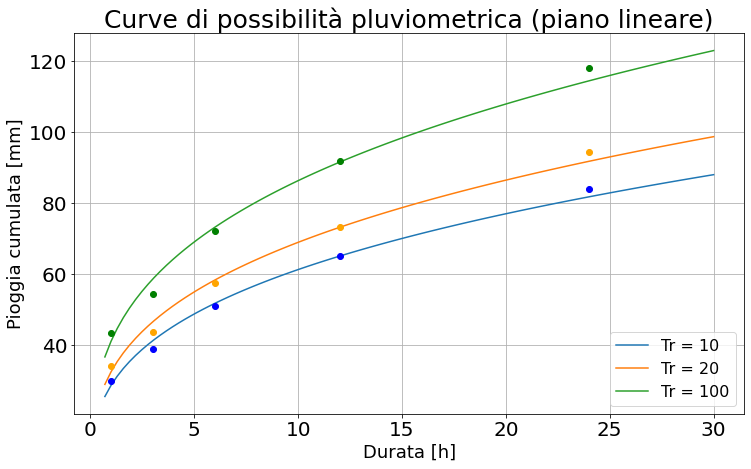

In [61]:
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
h2 = df_cpp.plot(figsize = (12,7))
h2.set_title('Curve di possibilità pluviometrica (piano lineare)', fontsize = 25)
h2.set_xlabel('Durata [h]', fontsize = 18)
h2.set_ylabel('Pioggia cumulata [mm]', fontsize = 18)
h2.set_xbound(lower = 0, upper = 30)
h2.grid()
h2 = plot(df_h_mm[10], "o", color="blue")
h2 = plot(df_h_mm[20], "o", color="orange")
h2 = plot(df_h_mm[100], "o", color="green")
plt.legend(prop = {"size":16}, loc = 4)

### Curve di possibilità pluviometrica nel piano bilogaritmico

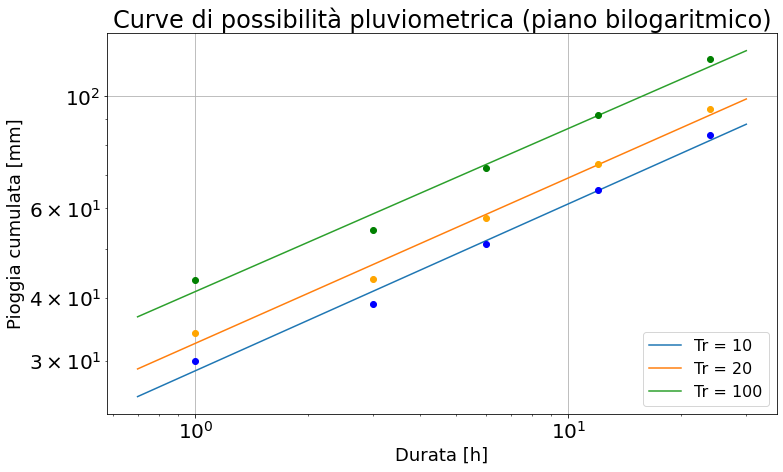

In [63]:
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
h3 = df_cpp.plot(figsize = (12,7))
h3.set_title('Curve di possibilità pluviometrica (piano bilogaritmico)', fontsize = 24)
h3.set_xlabel('Durata [h]', fontsize = 18)
h3.set_ylabel('Pioggia cumulata [mm]', fontsize = 18)
h3.set_yscale('log')
h3.set_xscale('log')
h3.grid()
h3 = plot(df_h_mm[10], "o", color="blue")
h3 = plot(df_h_mm[20], "o", color="orange")
h3 = plot(df_h_mm[100], "o", color="green")
plt.legend(prop = {"size":16}, loc = 4)

# Conclusioni

Lo scopo di questa esercitazione consiste nel realizzare le curve di possibilità pluviometrica relative ai massimi di precipitazione per la stazione meteorologica di Cavalese convento nell'intervallo temporale tra il 1962 e il 2002.

Per la realizzazione di tali curve si è resa necessaria la valutazione dei parametri a e b mediante il test di Pearson: da tale analisi statistica si evince che i parametri a e b migliori, per tutte le durate considerate, sono quelli determinati tramite il metodo dei mimini quadrati. Nel caso delle fasce orarie 1 ora e 24 ore il valore del $\chi^2$, per le singole durate, risulta essere uguale per i metodi dei minimi quadrati e della massima verosimiglianza.

Le curve di possibilità pluviometrica realizzate sono da considerarsi di buona qualità. Tale considerazione è corretta in quanto nel piano bilogaritmico le rette sono circa parallele; infatti risultano avere una pendenza simile con una variazione limitata. 

# Sitografia

* Dispense del Professor Riccardo Rigon:
    * <https://abouthydrology.blogspot.com/2022/02/the-hydrology-class-2022-lab-page.html>
    * <https://abouthydrology.blogspot.com/2022/02/the-hydrology-class-2022-schedule.html>
* Meteo Trentino (storico):
    * <http://storico.meteotrentino.it/web.htm?ppbm=T0107&rs&1&df>